In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score

In [2]:
df_train = pd.read_csv('dataset/train.tsv', sep='\t')
df_test = pd.read_csv('dataset/test.tsv', sep='\t')
df_train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [3]:
df_train.info(), df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66292 entries, 0 to 66291
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   PhraseId    66292 non-null  int64 
 1   SentenceId  66292 non-null  int64 
 2   Phrase      66292 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


(None, None)

In [4]:
df_train = df_train.head(1000)

In [5]:
sentiment = df_train['Sentiment'].value_counts()
sentiment = pd.DataFrame({'Sentiment': sentiment.index.tolist(), 'number': sentiment.values.tolist()})
sentiment

,Sentiment,number
0,2,670
1,1,139
2,3,139
3,4,37
4,0,15


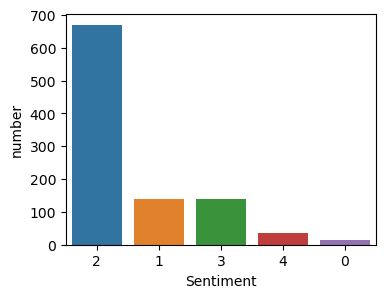

In [6]:
plt.figure(figsize=(4, 3))
sns.barplot(x='Sentiment', y='number', order=sentiment.Sentiment.tolist(), data=sentiment)
plt.show()

In [7]:
# nltk.download('wordnet')
# nltk.download('omw-1.4')

In [8]:
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()


def preprocess_sentence(df):
    for i in range(len(df)):
        sentence = re.sub(r'[^\w\s]', '', df['Phrase'][i].lower())  #删除单词字符(a-zA-Z0-9_)和空白符外的所有字符
        words = nltk.word_tokenize(sentence)
        words_clean = [word for word in words if not word in stop_words and len(word) > 3]  #删除停用词(包括长度<=2的)
        sentence_clean = ''
        for word in words_clean:
            sentence_clean += str(lemmatizer.lemmatize(word)) + ' '  #词形还原
        yield sentence_clean

In [9]:
df_train['phrase_clean'] = list(preprocess_sentence(df_train))
df_test['phrase_clean'] = list(preprocess_sentence(df_test))
df_train.head()

,PhraseId,SentenceId,Phrase,Sentiment,phrase_clean
0,1,1,A series of escapades demonstrating the adage ...,1,series escapade demonstrating adage good goose...
1,2,1,A series of escapades demonstrating the adage ...,2,series escapade demonstrating adage good goose
2,3,1,A series,2,series
3,4,1,A,2,
4,5,1,series,2,series


In [10]:
df_test.head()

,PhraseId,SentenceId,Phrase,phrase_clean
0,156061,8545,An intermittently pleasing but mostly routine ...,intermittently pleasing mostly routine effort
1,156062,8545,An intermittently pleasing but mostly routine ...,intermittently pleasing mostly routine effort
2,156063,8545,An,
3,156064,8545,intermittently pleasing but mostly routine effort,intermittently pleasing mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine,intermittently pleasing mostly routine


In [11]:
X_train_text = df_train['phrase_clean'].values
y_train = df_train['Sentiment'].values
X_test_text = df_test['phrase_clean'].values
X_train_text.shape, y_train.shape, X_test_text.shape

((1000,), (1000,), (66292,))

In [12]:
def acc_cv(clf):  #五折交叉验证
    acc = cross_val_score(clf, X_train, y_train, cv=5)
    return acc.mean(), acc.std()

### 词袋和ngram对比实验

In [13]:
vectorizer_bgow = CountVectorizer()
vectorizer_bgow.fit(X_train_text)
X_train = vectorizer_bgow.transform(X_train_text).toarray()
X_train.shape

(1000, 272)

In [14]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
acc_cv(clf)

(0.651, 0.0073484692283495405)

In [15]:
for i in range(1, 6):
    for j in range(i, 6):
        vectorizer_ngram = CountVectorizer(ngram_range=(i, j))
        vectorizer_ngram.fit(X_train_text)
        X_train = vectorizer_ngram.transform(X_train_text).toarray()
        clf = LogisticRegression()
        print(i, j, acc_cv(clf))

1 1 (0.651, 0.0073484692283495405)
1 2 (0.652, 0.018055470085267804)
1 3 (0.653, 0.017776388834631195)
1 4 (0.654, 0.01319090595827293)
1 5 (0.654, 0.01319090595827293)
2 2 (0.6580000000000001, 0.015033296378372923)
2 3 (0.6540000000000001, 0.015297058540778367)
2 4 (0.656, 0.014628738838327805)
2 5 (0.655, 0.014491376746189452)
3 3 (0.658, 0.010295630140987009)
3 4 (0.6600000000000001, 0.012247448713915901)
3 5 (0.6600000000000001, 0.012247448713915901)
4 4 (0.658, 0.011224972160321834)
4 5 (0.658, 0.011224972160321834)
5 5 (0.66, 0.01140175425099139)


结论：n-gram要比词袋好一些。综合考虑acc的均值和方差，3-gram看起来最好

### logistic回归和softmax回归对比实验

In [16]:
vectorizer_3gram = CountVectorizer(ngram_range=(3, 3))
vectorizer_3gram.fit(X_train_text)
X_train = vectorizer_3gram.transform(X_train_text).toarray()
clf1 = LogisticRegression(multi_class='multinomial')
clf2 = LogisticRegression(multi_class='ovr')
acc_cv(clf1), acc_cv(clf2)

((0.658, 0.010295630140987009), (0.656, 0.013928388277184131))

结论：softmax回归要比logistic回归好一点

### SGD不同损失函数对比实验

In [17]:
from sklearn.linear_model import SGDClassifier

loss_list = ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber',
             'epsilon_insensitive', 'squared_epsilon_insensitive']
for s in loss_list:
    clf = SGDClassifier(loss=s)
    print(s, acc_cv(clf))

hinge (0.648, 0.014352700094407337)
log_loss (0.648, 0.024819347291981736)
modified_huber (0.51, 0.23149514033776175)
squared_hinge (0.529, 0.1971902634513175)
perceptron (0.38499999999999995, 0.2804460732476032)


D:\Anaconda\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


squared_error (0.06399999999999999, 0.03104834939252005)
huber (0.656, 0.016552945357246864)
epsilon_insensitive (0.6520000000000001, 0.014000000000000012)
squared_epsilon_insensitive (0.127, 0.015033296378372906)


结论：最好的是损失函数是：huber、epsilon_insensitive、log_loss(交叉熵)

### SGD不同学习率对比实验

In [18]:
lr_list = [0.02, 0.01, 0.005, 0.002, 0.001]
for lr in lr_list:
    clf = SGDClassifier(loss='log_loss', learning_rate='constant', eta0=lr)
    print(lr, acc_cv(clf))

0.02 (0.658, 0.012884098726725137)
0.01 (0.661, 0.0073484692283495405)
0.005 (0.667, 0.006000000000000005)
0.002 (0.67, 0.0)
0.001 (0.67, 0.0)


结论：学习率偏大时无法收敛到或者错过了最优解。但是这个题看不出是否存在因为学习率太小而陷入局部最优解和平原区域

### shuffle使用与否的对比实验

验证集划分时的shuffle对比实验

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=False)
clf = LogisticRegression()
clf.fit(X_train_new, y_train_new)
accuracy_score(y_val, clf.predict(X_val))

0.62

In [20]:
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)
clf.fit(X_train_new, y_train_new)
accuracy_score(y_val, clf.predict(X_val))

0.695

SGD每个epoch data_loader时的shuffle对比实验

In [21]:
clf = SGDClassifier(loss='log_loss', shuffle=False)
acc_cv(clf)

(0.542, 0.20429390592966792)

In [22]:
clf = SGDClassifier(loss='log_loss', shuffle=True)
acc_cv(clf)

(0.648, 0.01749285568453592)

结论：shuffle可以明显减少过拟合，提高泛化能力。实验结果明显在验证集上准确率大幅提高了

batch与mini-batch对比实验用sklearn做不了，在numpy那边做了

用于kaggle提交的方案：

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectorizer.fit(X_train_text)
X_train = vectorizer.transform(X_train_text).toarray()
X_test = vectorizer.transform(X_test_text).toarray()
X_train.shape, X_test.shape

((1000, 272), (66292, 272))

In [24]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(learning_rate=0.01)
acc_cv(lgbm)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 9
[LightGBM] [Info] Start training from score -4.199705
[LightGBM] [Info] Start training from score -1.975082
[LightGBM] [Info] Start training from score -0.400478
[LightGBM] [Info] Start training from score -1.975082
[LightGBM] [Info] Start training from score -3.283414
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

(0.67, 0.0)

In [25]:
lgbm.fit(X_train,y_train)
y_pred=lgbm.predict(X_test)
df_submit = pd.DataFrame({'PhraseId':df_test['PhraseId'], 'Sentiment':y_pred})
df_submit.head()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 101
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 11
[LightGBM] [Info] Start training from score -4.199705
[LightGBM] [Info] Start training from score -1.973281
[LightGBM] [Info] Start training from score -0.400478
[LightGBM] [Info] Start training from score -1.973281
[LightGBM] [Info] Start training from score -3.296837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2


In [26]:
df_submit.to_csv('output/submission.csv',index=False)